In [1]:
from collections import defaultdict
import copy
import matplotlib.pyplot as plt
from circuit.parser import get_circuit_duration
from plot.plot import plot_duration_fidelity, plot_top_ratio, find_error_path
import random
import numpy as np

from circuit import gen_random_circuits, label_ground_truth_fidelity
from upstream import RandomwalkModel
from downstream import FidelityModel
from simulator import NoiseSimulator
from utils.backend import devide_chip, gen_grid_topology, get_grid_neighbor_info, Backend, topology_to_coupling_map
from utils.backend import default_basis_single_gates, default_basis_two_gates
import pickle


In [2]:
with open(f"execute_18bit_new/step1/downstream_model.pkl","rb")as f:
    downstream_model = pickle.load(f)
upstream_model = downstream_model.upstream_model

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
from scipy import io as sio
all_results_load = sio.loadmat("1800.mat")
last = sio.loadmat("300_last.mat")

In [6]:
all_results_load['circuit No.4.0 measure_counts']

array([[595,  12,   8,   1,  23,   2,  19,   2,   7,   1,   1,  14,   1,
          1,   5,   1,  20,   1,   1,  57,   1,   2,   1,   1,   3,   1,
          1,   1,   2,   7,   1,  26,   1,   1,   2,   1,   1,   1,   1,
          4,  13,   1,   2,   1,   1,   1,   1,   1,  26,   2,   3,   1,
          2,   1,   1,   3,   1,  47,   1,   1,   1,   1,   1,   6,   1,
          4,   1,   1,   1,   4,   1,   1,   1,   7,   1,   1,  13,   1,
          1,   1,   1,   2,   1,   1,   1,   2,   1,   1]], dtype=int32)

In [4]:
last.keys()

dict_keys(['__header__', '__version__', '__globals__', 'circuit No.4.0 measure_counts', 'circuit No.4.0 state_index', 'circuit No.4.1 measure_counts', 'circuit No.4.1 state_index', 'circuit No.4.2 measure_counts', 'circuit No.4.2 state_index', 'circuit No.4.3 measure_counts', 'circuit No.4.3 state_index', 'circuit No.4.4 measure_counts', 'circuit No.4.4 state_index', 'circuit No.4.5 measure_counts', 'circuit No.4.5 state_index', 'circuit No.4.6 measure_counts', 'circuit No.4.6 state_index', 'circuit No.4.7 measure_counts', 'circuit No.4.7 state_index', 'circuit No.4.8 measure_counts', 'circuit No.4.8 state_index', 'circuit No.4.9 measure_counts', 'circuit No.4.9 state_index', 'circuit No.4.10 measure_counts', 'circuit No.4.10 state_index', 'circuit No.4.11 measure_counts', 'circuit No.4.11 state_index', 'circuit No.4.12 measure_counts', 'circuit No.4.12 state_index', 'circuit No.4.13 measure_counts', 'circuit No.4.13 state_index', 'circuit No.4.14 measure_counts', 'circuit No.4.14 stat

In [7]:
with open('execute_more_info_300.pkl','rb') as f:
    dataset_300 = pickle.load(f)
    print(len(dataset_300))
    for i, cir in enumerate(dataset_300):
        assert 'devide_qubits' not in cir or cir['devide_qubits'] is None


360


In [8]:
single_average_error_rb = {0: 0.9994094148043156, # rb
 1: 0.9993508083886652,
 2: 0.9993513578387458,
 3: 0.9996978330672296,
 4: 0.9997258463524775,
 5: 0.9993898065578337,
 6: 0.9998335484697743,
 7: 0.9997460044815009,
 8: 0.9997219426985601,
 9: 0.9992924485427597,
 10: 0.9994018918682177,
 11: 0.9998410411794697,
 12: 0.9994231683912435,
 13: 0.9995938422219371,
 14: 0.9947661045069707,
 15: 0.9997576786354693,
 16: 0.9998387638441334,
 17: 0.9996691783504945}
couple_average_error_rb = {(5,11): 0.993651602350742, # rb
 (11,17): 0.9943374306798481,
 (4,5): 0.9810612795342519,
 (10,11): 0.9915544427978213,
 (16,17): 0.9908639448675425,
 (4,10): 0.9914941121128581,
 (10,16): 0.9868303060599511,
 (3,4): 0.9899226069903224,
 (9,10): 0.9945250360193374,
 (15,16): 0.9933864398113101,
 (3,9): 0.991508018299962,
 (9,15): 0.993773364368622,
 (2,3): 0.9802169505904027,
 (8,9): 0.9912794178832776,
 (14,15): 0.9867247971867894,
 (2,8): 0.9765590682588615,
 (8,14): 0.9863913339619792,
 (1,2): 0.9713229087974011,
 (7,8): 0.9908463216114999,
 (13,14): 0.9564265490465305,
 (1,7): 0.9856880460026779,
 (7,13): 0.9935440562158602,
 (0,1): 0.9833453296232256,
 (6,7): 0.9939901490743566,
 (12,13): 0.9821366244436676,
 (0,6): 0.9861987068804432,
 (6,12): 0.9863008252688662}
single_average_error_xeb = {0: 0.9994, #xeb
 1: 0.99956,
 2: 0.99918,
 3: 0.99976,
 4: 0.9994,
 5: 0.99962,
 6: 0.99989,
 7: 0.99973,
 8: 0.99961,
 9: 0.99941,
 10: 0.99975,
 11: 0.99939,
 12: 0.99873,
 13: 0.9996,
 14: 0.99946,
 15: 0.99976,
 16: 0.99977,
 17: 0.99975}
couple_average_error_xeb = {(5, 11): 0.98602, # xeb
 (11, 17): 0.99561,
 (4, 5): 0.99482,
 (10, 11): 0.99529,
 (16, 17): 0.996,
 (4, 10): 0.9908,
 (10, 16): 0.99501,
 (3, 4): 0.99738,
 (9, 10): 0.99373,
 (15, 16): 0.9934499999999999,
 (3, 9): 0.99659,
 (9, 15): 0.99357,
 (2, 3): 0.99353,
 (8, 9): 0.98778,
 (14, 15): 0.9956,
 (2, 8): 0.98862,
 (8, 14): 0.99711,
 (1, 2): 0.99445,
 (7, 8): 0.97725,
 (13, 14): 0.99527,
 (1, 7): 0.99098,
 (7, 13): 0.99424,
 (0, 1): 0.99394,
 (6, 7): 0.99452,
 (12, 13): 0.99141,
 (0, 6): 0.99474,
 (6, 12): 0.99312}
from upstream.randomwalk_model import extract_device
def get_rb_fidelity(circuit_info):
    fidelity = 1
    for gate in circuit_info['gates']:
        device = extract_device(gate)
        if isinstance(device,tuple):
            if 'map' in circuit_info:
                device = (circuit_info['map'][device[0]],circuit_info['map'][device[1]])
            fidelity = fidelity * couple_average_error_rb[device]
        else:
            if 'map' in circuit_info:
                device = circuit_info['map'][device]
            fidelity = fidelity * single_average_error_rb[device]
    return fidelity #* np.product((measure0_fidelity + measure1_fidelity) / 2)
from upstream.randomwalk_model import extract_device
def get_xeb_fidelity(circuit_info):
    fidelity = 1
    for gate in circuit_info['gates']:
        device = extract_device(gate)
        if isinstance(device,tuple):
            if 'map' in circuit_info:
                device = (circuit_info['map'][device[0]],circuit_info['map'][device[1]])
            fidelity = fidelity * couple_average_error_xeb[device]
        else:
            if 'map' in circuit_info:
                device = circuit_info['map'][device]
            fidelity = fidelity * single_average_error_xeb[device]
    return fidelity #* np.product((measure0_fidelity + measure1_fidelity) / 2)

In [9]:
predicts,xebs,rbs = [],[],[]
for i, cir in enumerate(dataset_300):
    new_cir = upstream_model.vectorize(cir)
    predict = downstream_model.predict_fidelity(new_cir)
    predicts.append(predict)
    xebs.append(get_xeb_fidelity(new_cir))
    rbs.append(get_rb_fidelity(new_cir))

In [10]:
reals = []
for day in range(1,5):
    cnt = 0
    real = []
    for idx, cir in enumerate(dataset_300):
        state_count = dict([(s, cnt) for s, cnt in zip(
                            np.squeeze(all_results_load[f'circuit No.{day}.{idx} state_index']), 
                            np.squeeze(all_results_load[f'circuit No.{day}.{idx} measure_counts']))])
        cir['state_count'] = state_count
        if 0 not in state_count:
            cnt += 1
            continue
        real.append(state_count[0] / 1000)
    reals.append(real)
    print(cnt)

real = []
for idx, cir in enumerate(dataset_300):
    state_count = dict([(s, cnt) for s, cnt in zip(
                        np.squeeze(last[f'circuit No.{4}.{idx} state_index']), 
                        np.squeeze(last[f'circuit No.{4}.{idx} measure_counts']))])
    cir['state_count'] = state_count
    if 0 not in state_count:
        cnt += 1
        continue
    real.append(state_count[0] / 1000)
reals.append(real)        

0
0
0
0


In [12]:
import  matplotlib.pyplot as plt
deltas = []
for real in reals:
    real= np.array(real)
    predicts = np.array(predicts)
    xebs = np.array(xebs)
    rbs = np.array(rbs)
    deltas.append(np.abs(real - predicts))
    deltas.append(np.abs(rbs - real))
    deltas.append(np.abs(xebs - real))

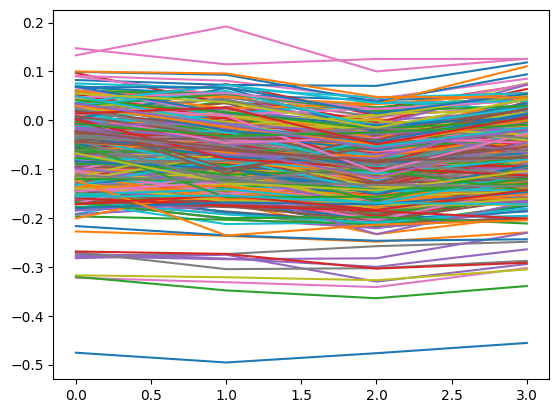

In [70]:
circuit_timelines = np.zeros((360, 4))

_predicts = predicts
for circuit_index in range(360):
    for day in range(4):
        circuit_timelines[circuit_index][day] = reals[day][circuit_index] - _predicts[circuit_index]
        
for circuit_index in range(360):
    plt.plot(list(range(4)), circuit_timelines[circuit_index])

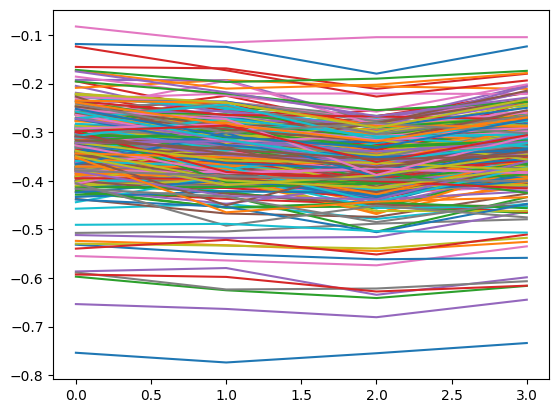

In [71]:
circuit_timelines = np.zeros((360, 4))

_predicts = rbs
for circuit_index in range(360):
    for day in range(4):
        circuit_timelines[circuit_index][day] = reals[day][circuit_index] - _predicts[circuit_index]
        
for circuit_index in range(360):
    plt.plot(list(range(4)), circuit_timelines[circuit_index])

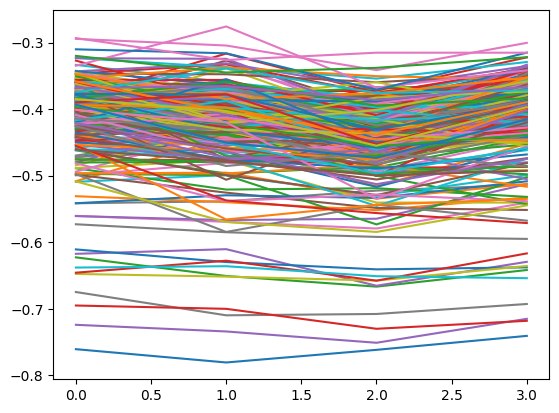

In [72]:
circuit_timelines = np.zeros((360, 4))

_predicts = xebs
for circuit_index in range(360):
    for day in range(4):
        circuit_timelines[circuit_index][day] = reals[day][circuit_index] - _predicts[circuit_index]
        
for circuit_index in range(360):
    plt.plot(list(range(4)), circuit_timelines[circuit_index])

<AxesSubplot: >

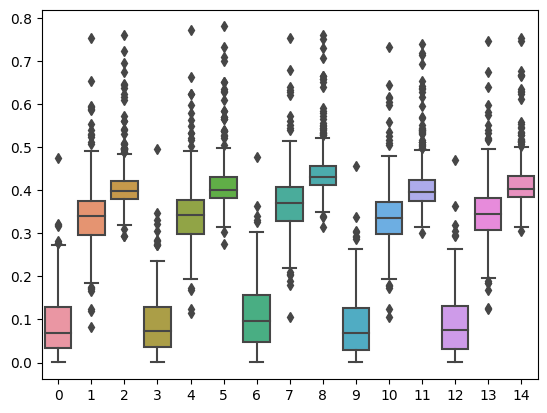

In [13]:
import seaborn as sns
sns.boxplot(x=None,y=None,data=deltas)

In [15]:
import  matplotlib.pyplot as plt
deltas_rb = []
deltas_xeb = []
deltas_quct = []
for real in reals:
    real= np.array(real)
    predicts = np.array(predicts)
    xebs = np.array(xebs)
    rbs = np.array(rbs)
    deltas_rb.append(np.abs(real - predicts).mean())
    deltas_xeb.append(np.abs(rbs - real).mean())
    deltas_quct.append(np.abs(xebs - real).mean())

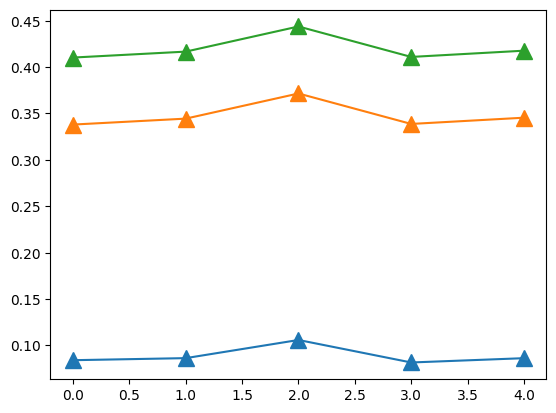

In [16]:
fig, axes = plt.subplots()
x = np.arange(len(deltas_rb))
axes.plot(x, deltas_rb , marker = '^',markersize= 12)
axes.plot(x, deltas_xeb, marker = '^',markersize= 12)
axes.plot(x, deltas_quct, marker = '^',markersize= 12)
fig.savefig('____.svg')

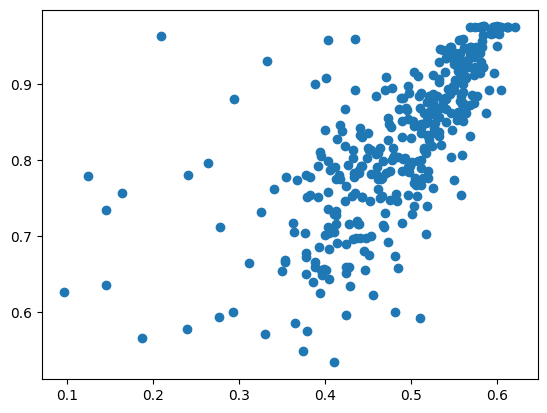

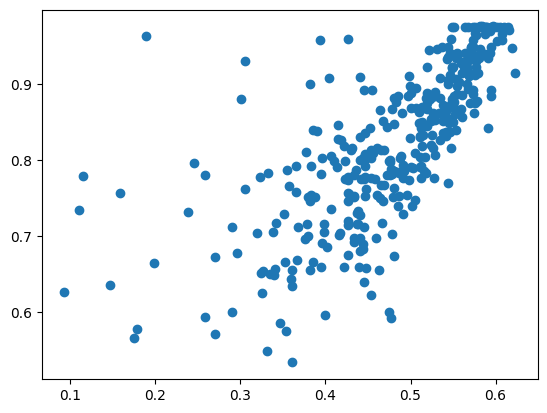

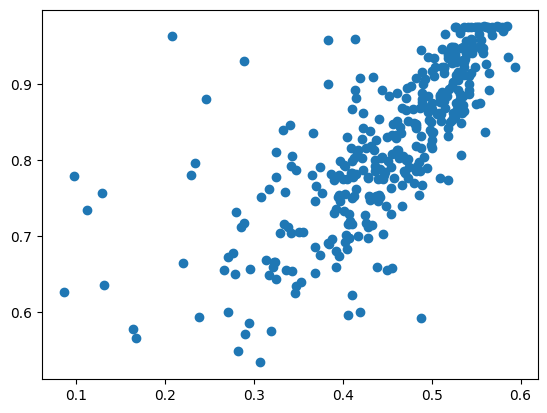

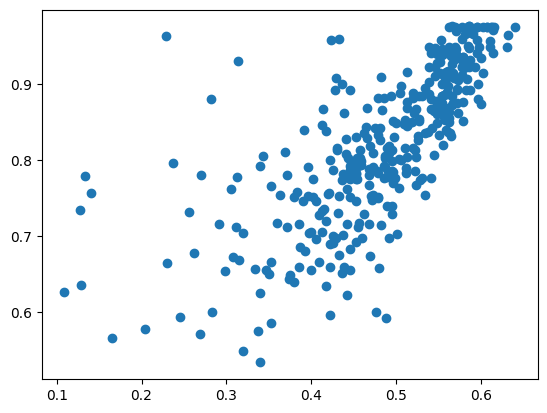

In [66]:
import  matplotlib.pyplot as plt
deltas_rb = []
for real in reals:
    # rbs = np.array(rbs)
    plt.scatter(real, rbs)
    plt.show()

In [63]:
# import  matplotlib.pyplot as plt
# deltas_rb = []
# deltas_xeb = []
# deltas_quct = []
# for real in reals:
#     real= np.array(real)
#     predicts = np.array(predicts)
#     xebs = np.array(xebs)
#     rbs = np.array(rbs)
#     deltas_rb.append(np.abs(real - predicts))
#     deltas_xeb.append(np.abs(rbs - real))
#     deltas_quct.append(np.abs(xebs - real))

In [69]:
d_deltas_rb = []
d_deltas_xeb = []
d_deltas_quct = []
for i in range(1, 3):
    d_deltas_rb.append(deltas_rb[i] - deltas_rb[0])
    d_deltas_rb.append(deltas_rb[i] - deltas_rb[0])
    d_deltas_rb.append(deltas_rb[i] - deltas_rb[0])

IndexError: list index out of range

In [36]:

from plot.plot import plot_correlation


def sumarize_datasize(dataset, name):
    data = []
    labels = []
    for circuit_info in dataset:
        data.append([len(circuit_info['gates']),
                     circuit_info['ground_truth_fidelity'], circuit_info['duration'], len(circuit_info['layer2gates']),
        ])
        # labels.append(circuit_info['label'])

    random.shuffle(data)
    data = data[:3000]  # 太大了画出来的图太密了
    data = np.array(data)
    plot_correlation(data, [
                            'n_gates', 'ground_truth_fidelity', 'duration', 'depth',], color_features=None, name=name)

/home/luliqiang/miniconda3/envs/ISCA/lib/python3.9/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/luliqiang/miniconda3/envs/ISCA/lib/python3.9/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/luliqiang/miniconda3/envs/ISCA/lib/python3.9/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/luliqiang/miniconda3/envs/ISCA/lib/python3.9/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/luliqiang/miniconda3/envs/ISCA/lib/python3.9/site-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/home

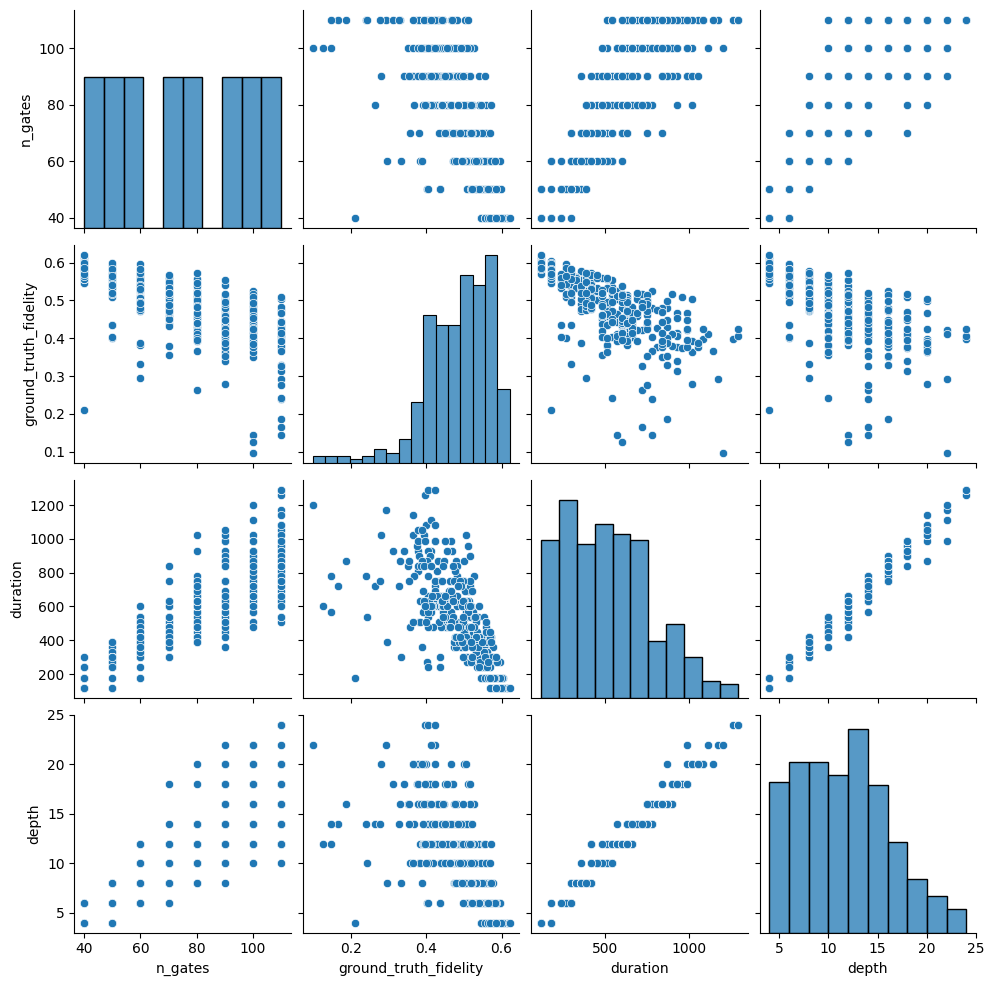

In [37]:
sumarize_datasize(test_dataset,'time_300.svg')